In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as sc

sns.set(style="darkgrid")
sns.set_palette(sns.cubehelix_palette(8))
    

/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Data imports

# All logged emergency, sorted by involved car
time = pd.read_csv("arrival_time_by_unit.csv", delimiter = ",")

# All logged emergency, sorted by emergency_nbr. This dataset also included comments about from the reports, which I've choosen to remove from for GitHub. 
comments = pd.read_csv("comments.csv", delimiter = ",")


In [3]:
time.head()

,Unnamed: 0,emergency_nbr,municipaly,unit,date,arrival_time
0,0,G2020.100892,Municipaly A,263-5010,2020-09-12,22:53:55
1,1,G2020.098990,Municipaly A,263-5010,2020-09-08,05:32:30
2,2,G2020.096994,Municipaly A,263-5010,2020-09-02,20:34:52
3,3,G2020.095119,Municipaly A,263-5010,2020-08-29,10:22:43
4,4,G2020.094904,Municipaly A,263-5010,2020-08-28,20:34:00


In [4]:
# Start by looking att the arrival times
# Processing

# delete nans, can afford it since the dataset is sufficently large
time.isnull().sum()
time = time.dropna()
    
# For this I only wish to study the two main municipalities A and B
time = time[time.municipaly.str.contains("Municipaly A") | time.municipaly.str.contains("Municipaly B")]
    
time["index"] = range(len(time))
time = time.set_index("index")
    
    
# fix date-time
time["Date_time"] = time["date"] +  " " + time["arrival_time"]
time = time.drop(["date", "arrival_time"], axis =1)
    
# Seems to be mistakes made in a few reports
time = time[~time.Date_time.str.contains("1900-01-00 00:00:00")]
time = time.reset_index()
time = time.drop(["index"], axis =1)
    
    
for k in range(len(time)):
    date_time_str = time["Date_time"][k]
    date_time_obj = dt.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    time["Date_time"][k] = date_time_obj

time.head()

/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,emergency_nbr,municipaly,unit,Date_time
0,0,G2020.100892,Municipaly A,263-5010,2020-09-12 22:53:55
1,1,G2020.098990,Municipaly A,263-5010,2020-09-08 05:32:30
2,2,G2020.096994,Municipaly A,263-5010,2020-09-02 20:34:52
3,3,G2020.095119,Municipaly A,263-5010,2020-08-29 10:22:43
4,4,G2020.094904,Municipaly A,263-5010,2020-08-28 20:34:00


In [5]:
# Encoding for type of unit
time["Unit_1"] = 0 
time["Unit_2"] = 0  
time["Unit_3"] = 0  
time["Unit_4"] = 0

for k in range(len(time)):
        
        if time["unit"][k] == "263-5060" or time["unit"][k] == "263-5070" or time["unit"][k] == "263-5090" or time["unit"][k] == "263-6060" or time["unit"][k] == "263-6070" or time["unit"][k] == "263-6090" or time["unit"][k] == "263-5075" or time["unit"][k] == "263-6075" or time["unit"][k] == "263-5175":
            time["Unit_1"][k] = 1   
      
        if time["unit"][k] == "263-5010" or time["unit"][k] == "263-5020" or time["unit"][k] == "263-6010" or time["unit"][k] == "263-6040":
            time["Unit_2"][k] = 1
        
        if time["unit"][k] == "263-5860" or time["unit"][k] == "263-5870":
            time["Unit_3"][k] = 1
            
        if time["unit"][k] == "263-5080":
            time["Unit_4"][k] = 1
    
    
# group by emrg_nbr in a dict
data = {k: insats for k, insats in time.groupby("emergency_nbr")}

/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [6]:
# Combine with the second dataset
for k in range(len(comments)):
     if comments.emergency_nbr[k] in data:
        data[comments.emergency_nbr[k]]["type"] = comments.type[k]


In [7]:
# Analysis of what units are first on site

# Counters
only_1 = 0
count_1 = 0
only_1_type = []
first_1 = 0


first_2 =0
count_2 =0

diff_list = []
diff_list2 = []

first_3 = 0
count_3 = 0
diff_3_list = []

first_4 = 0
count_4 = 0



for item in data:
        
    if any(data[item]["Unit_3"] == 1):
        count_3 +=1
    if any(data[item]["Unit_4"] == 1):
        count_4 +=1
    if any(data[item]["Unit_2"] == 1):
        count_2 +=1
    if any(data[item]["Unit_1"] == 1):
        count_1 +=1
        
    if all(data[item]["Unit_1"] == 1):
        only_1 +=1 
        only_1_type.append(data[item]["type"].iloc[0])
        continue
    else:
        data[item] = data[item].sort_values(by=["Date_time"])
        data[item]["index"] = range(len(data[item]))
        data[item] = data[item].set_index("index")
            
        # om första bilen är en offensiv, hur lång tid innan en stor bil kom?
        if data[item]["Unit_1"][0] == 1:
            first_1 +=1
            for i in range(1,len(data[item])): 
                if data[item]["Unit_2"][i] == 1:
                    time_diff = data[item]["Date_time"][i] - data[item]["Date_time"][0]
                    diff_list.append(time_diff) 
                    break
            
        # om tryggv kommer först och hur mycket förre tvåan
        elif data[item]["Unit_3"][0] == 1:
            first_3 +=1 
            diff_3 = data[item]["Date_time"][1] - data[item]["Date_time"][0]
            diff_3_list.append(diff_3)
            
        elif data[item]["Unit_4"][0] == 1:
             first_4 +=1
                
        # i några fall har flera bilar samma tid, om så är fallet mellan släkc och off kan de hamna här, samtidigt händer de säkert åt båda hållen, noteras dock som 0 sek då. tycker det finns myckert som inte är exakt redan
        elif data[item]["Unit_2"][0] == 1:
            first_2 +=1
            # hur mycket efter är den första offensiva enheten?
            for i in range(1,len(data[item])): 
                if data[item]["Unit_1"][i] == 1:
                    time_diff2 = data[item]["Date_time"][i] - data[item]["Date_time"][0]
                    diff_list2.append(time_diff2) 
                    break
                    
print("Unit 1 only: ", only_1,"\n",
          "Unit 1 first: ", first_1,"\n",
          "Unit 1 total: ", count_1,"\n", 
          "Unit 3 first: ", first_3,"\n",
          "Unit 3 total: ", count_3,"\n",
          "Unit 4 first: ", first_4,"\n",
          "Unit 4 total: ", count_4,"\n", 
          "Unit 2 first: ", first_2,"\n",
          "Unit 2 total: ", count_2,"\n", 
          "Totalt number of emergencies: ", len(data))
                    


Unit 1 only:  732 
 Unit 1 first:  960 
 Unit 1 total:  1811 
 Unit 3 first:  10 
 Unit 3 total:  31 
 Unit 4 first:  85 
 Unit 4 total:  613 
 Unit 2 first:  57 
 Unit 2 total:  1061 
 Totalt number of emergencies:  1844


In [8]:
# Time differences between the first Unit 1 and the first Unit 2
for k in range(len(diff_list)):
    diff_list[k] = diff_list[k].total_seconds()


# Combined with the case where unit 2 is first
total_tidsdiff = diff_list.copy()
for k in range(len(diff_list2)):
    diff_list2[k] = diff_list2[k].total_seconds()
    diff_list2[k] = diff_list2[k] *-1
    total_tidsdiff.append(diff_list2[k])
    
    
    
# Confidence Intervall of difference

def confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m = np.mean(a) 
    error = sc.sem(a)
    limit = error * sc.t.ppf((1 + confidence) / 2., n-1)
    return m-limit, m, m+limit

print(confidence_interval(total_tidsdiff, 0.999))



(285.92494376886066, 327.2964467005076, 368.66794963215455)


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of difference in time between first unit 1 and unit 2')]

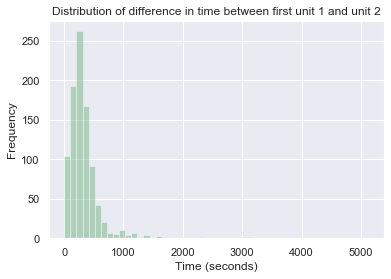

In [9]:
sns.distplot(diff_list, color="g", kde=False,axlabel="Time (seconds)").set(
        title="Distribution of difference in time between first unit 1 and unit 2",
        ylabel="Frequency")



[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of difference in time between first unit 1 and unit 2')]

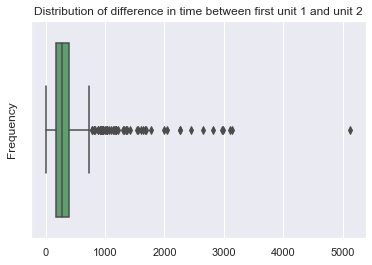

In [10]:
sns.boxplot(diff_list, color="g").set(
        title="Distribution of difference in time between first unit 1 and unit 2",
        ylabel="Frequency")

In [11]:
avg = np.mean(diff_list)
med = np.median(diff_list)
std = np.std(diff_list)
print("Avg: ",avg,", Med: ", med," , Std: ", std)

Avg:  350.8603411513859 , Med:  271.0  , Std:  379.5521189320528


In [12]:
# Divided into type of emergency
df_only_1 = pd.DataFrame(only_1_type, columns=["Type of emergency"])
df_only_1.head()



,Type of emergency
0,Annat sjukvårdslarm
1,Automatlarm utan brandtillbud
2,Automatlarm utan brandtillbud
3,Annat sjukvårdslarm
4,Hjärtstoppslarm


<function matplotlib.pyplot.show(*args, **kw)>

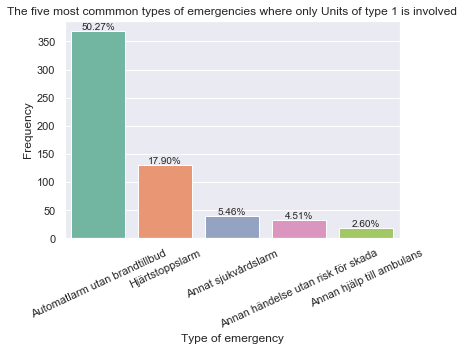

In [13]:
total = float(len(df_only_1))

ax = sns.countplot(x="Type of emergency", data = df_only_1,
                   palette="Set2",order=df_only_1["Type of emergency"].value_counts()[:5].index)
plt.xticks(rotation=25)
ax.set_title("The five most commmon types of emergencies where only Units of type 1 is involved")
ax.set_ylabel("Frequency")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            "{:1.2f}%".format(np.round(100*height/total,2),"%"),
            ha="center")
plt.show


In [14]:
# The seconds most common type of emergency is "Hjärtstoppslarm", lets look closer at this one
hjt = {}
for item in data:
    if data[item]["type"].iloc[0] == "Hjärtstoppslarm":
        hjt[item] = data[item]

hjt_off =0
for item in hjt:
    if all(hjt[item]["Unit_1"] == 1):
        hjt_off +=1 
    else:
        print(item)

G2020.041340
G2020.056318


In [15]:
# Out of the 133 emergencies only 2 were not handeled by Unit 1s only

In [16]:
# Further I study the seconds dataset "comments"

In [17]:
data_17 = comments[comments.emergency_nbr.str.contains("2017")]
data_18 = comments[comments.emergency_nbr.str.contains("2018")]
data_19 = comments[comments.emergency_nbr.str.contains("2019")]
data_20 = comments[comments.emergency_nbr.str.contains("2020")]

data_17["year"] = 2017
data_18["year"] = 2018
data_19["year"] = 2019
data_20["year"] = 2020


comments_by_year = pd.concat([data_17, data_18, data_19, data_20])


dict_by_year = {"2017" : data_17,
            "2018" : data_18,
            "2019" : data_19,
            "2020" : data_20}

/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

<function matplotlib.pyplot.show(*args, **kw)>

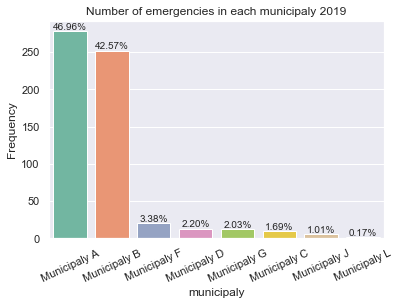

In [18]:
# 2019
ax = sns.countplot(dict_by_year["2019"]["municipaly"],palette="Set2",order=dict_by_year["2019"]["municipaly"].value_counts().index)
ax.set_title("Number of emergencies in each municipaly 2019")
ax.set_ylabel("Frequency")
plt.xticks(rotation=25)

total = float(len(dict_by_year["2019"]))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            "{:1.2f}%".format(np.round(100*height/total,2),"%"),
            ha="center")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

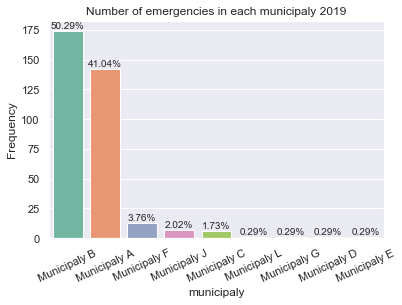

In [19]:
#2020
ax = sns.countplot(dict_by_year["2020"]["municipaly"],palette="Set2",order=dict_by_year["2020"]["municipaly"].value_counts().index)
ax.set_title("Number of emergencies in each municipaly 2019")
ax.set_ylabel("Frequency")
plt.xticks(rotation=25)

total = float(len(dict_by_year["2020"]))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            "{:1.2f}%".format(np.round(100*height/total,2),"%"),
            ha="center")
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

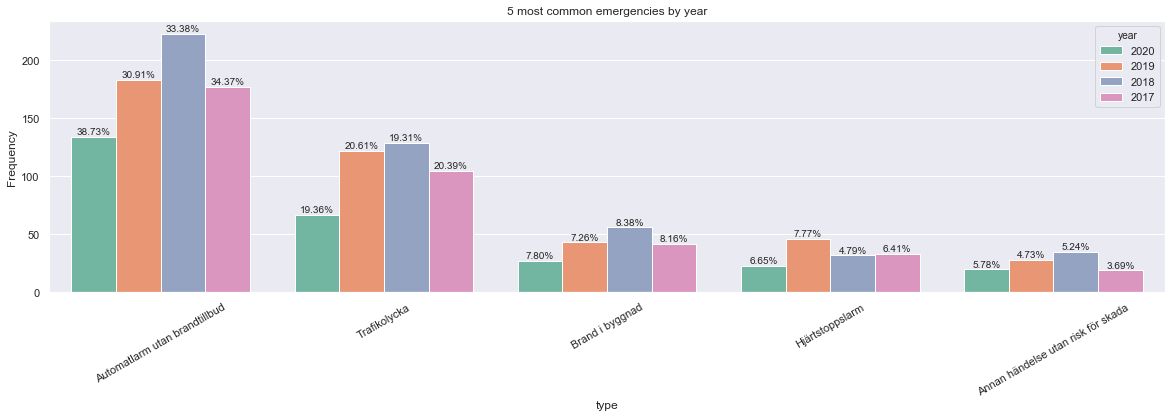

In [20]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(data=comments_by_year, x="type",hue="year", hue_order=[2020, 2019, 2018, 2017],
              order=comments_by_year["type"].value_counts().iloc[:5].index,
              palette="Set2")
plt.xticks(rotation=30)
ax.set(ylabel ="Frequency",title="5 most common emergencies by year")

for k in range(len(ax.patches)):
    if k == 0 or k == 1 or k == 2 or k == 3 or k == 4:
        total = float(len(data_20))
    elif k == 5 or k == 6 or k == 7 or k == 8 or k == 9:
        total = float(len(data_19))
    elif k == 10 or k == 11 or k == 12 or k == 13 or k == 14:
        total = float(len(data_18))
    elif k == 15 or k == 16 or k == 17 or k == 18 or k == 19:
        total = float(len(data_17))
        
    height = ax.patches[k].get_height()
    ax.text(ax.patches[k].get_x()+ax.patches[k].get_width()/2.,
            height + 2,
            "{:1.2f}%".format(np.round(100*height/total,2),"%"),
            ha="center")
plt.show

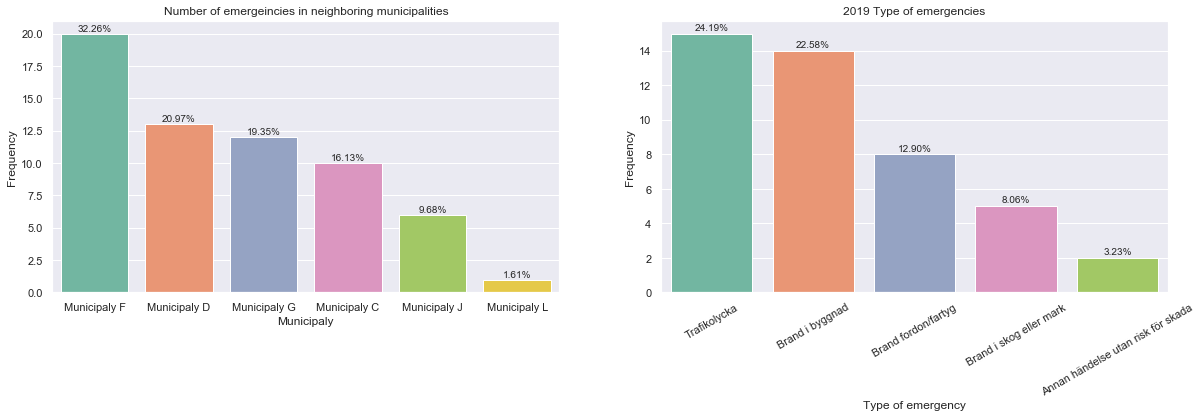

In [21]:
# Emergencies outside of the two main municipalies A and B

outside = data_19[~data_19.municipaly.str.contains("Municipaly A")]
outside = outside[~outside.municipaly.str.contains("Municipaly B")]


fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(outside["municipaly"],ax=ax[0],palette="Set2",order=outside["municipaly"].value_counts().index)
ax[0].set(xlabel="Municipaly",ylabel ="Frequency", title="Number of emergeincies in neighboring municipalities")
total = len(outside)
for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x()+p.get_width()/2.,
            height + 0.2,
            "{:1.2f}%".format(np.round(100*height/total,2),"%"),
            ha="center")

sns.countplot(outside["type"],ax=ax[1],palette="Set2",order=outside["type"].value_counts().iloc[:5].index)
ax[1].set(xlabel="Type of emergency",ylabel ="Frequency", title="2019 Type of emergencies")
plt.xticks(rotation=30)
for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x()+p.get_width()/2.,
            height + 0.2,
            "{:1.2f}%".format(np.round(100*height/total,2),"%"),
            ha="center")
